# 💳 Segmentación de Clientes (Clustering de Tarjetas de Crédito)

## 1. Introducción y Objetivo
**¿El Problema?** Un banco tiene miles de clientes con tarjetas de crédito, pero no sabe cómo tratarlos. No puede ofrecerle lo mismo a alguien que gasta mucho que a alguien que solo saca efectivo.

**La Solución:** Usaremos un algoritmo de Inteligencia Artificial llamado **K-Means** para agrupar a los clientes automáticamente en "Perfiles" basados en su comportamiento.

**El Resultado:** Encontraremos grupos como "Los Ahorradores", "Los Gastadores VIP", etc.

In [2]:
# 1. Importación de Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Algoritmos de Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Métricas de Evaluación
from sklearn.metrics import silhouette_score

# Configuración visual
sns.set_style('whitegrid')
%matplotlib inline

## 2. Carga de Datos (Raw Data)
Cargamos el archivo `CC GENERAL.csv`. Cada fila es un cliente y cada columna es un comportamiento (cuánto gastó, cuánto pagó, límite de crédito, etc.).

In [3]:
df = pd.read_csv('CC GENERAL.csv')

print(f"Dimensiones del Dataset: {df.shape}")
print("\n--- Primeras 5 filas (Datos Crudos) ---")
display(df.head())

Dimensiones del Dataset: (8950, 18)

--- Primeras 5 filas (Datos Crudos) ---


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## 3. Limpieza y Preprocesamiento (Paso a Paso)

### 3.1 Tratamiento de Valores Nulos (Missing Values)
En datos financieros es común tener huecos. Vamos a buscar dónde están.

In [4]:
# Verificamos nulos por columna
nulos = df.isnull().sum()
nulos = nulos[nulos > 0] # Mostramos solo las que tienen problemas

print("Columnas con valores vacíos (NaN):")
print(nulos)

print("\n--- Estrategia de Corrección ---")
print("Usaremos la MEDIANA para rellenar estos huecos.")
print("¿Por qué? Porque la media es muy sensible a millonarios (outliers), la mediana es más realista.")

Columnas con valores vacíos (NaN):
CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64

--- Estrategia de Corrección ---
Usaremos la MEDIANA para rellenar estos huecos.
¿Por qué? Porque la media es muy sensible a millonarios (outliers), la mediana es más realista.


In [5]:
# Corrección de Nulos (Sintaxis moderna)
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median())
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median())

# Eliminamos CUST_ID (No sirve para agrupar, es solo un nombre)
if 'CUST_ID' in df.columns:
    df.drop('CUST_ID', axis=1, inplace=True)

print(f"Nulos restantes después de la limpieza: {df.isnull().sum().sum()}")
print("¡Dataset limpio!")

Nulos restantes después de la limpieza: 0
¡Dataset limpio!


### 3.2 Escalado de Datos (StandardScaler)

**El Problema:**
*   `BALANCE` puede ser de $5,000 dólares.
*   `PURCHASES_FREQUENCY` es de 0 a 1.

Si no hacemos nada, el modelo K-Means le dará toda la importancia al dinero y ignorará la frecuencia. 

**La Solución:**
Usaremos `StandardScaler` para poner a todos en la misma escala (Media 0, Desviación 1).

In [6]:
# Mostramos un ejemplo antes
print("Datos Originales (BALANCE vs FRECUENCIA):")
display(df[['BALANCE', 'PURCHASES_FREQUENCY']].head(3))

# Escalamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Convertimos a DataFrame para ver el cambio
X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns)

print("\nDatos Escalados (Ahora ambos son comparables):")
display(X_scaled_df[['BALANCE', 'PURCHASES_FREQUENCY']].head(3))

Datos Originales (BALANCE vs FRECUENCIA):


,BALANCE,PURCHASES_FREQUENCY
0,40.900749,0.166667
1,3202.467416,0.000000
2,2495.148862,1.000000



Datos Escalados (Ahora ambos son comparables):


,BALANCE,PURCHASES_FREQUENCY
0,-0.731989,-0.806490
1,0.786961,-1.221758
2,0.447135,1.269843


## 4. Encontrando el Número Mágico de Grupos (K)

¿Cuántos tipos de clientes existen? ¿3? ¿5? ¿10?
Para saberlo, usamos dos técnicas gráficas:

1.  **Método del Codo (Elbow):** Buscamos dónde la curva deja de bajar rápido (se forma un "codo").
2.  **Silhouette Score:** Mide qué tan bien separados están los grupos. (Más alto es mejor).

Calculando k óptimo (esto puede tardar unos segundos)...


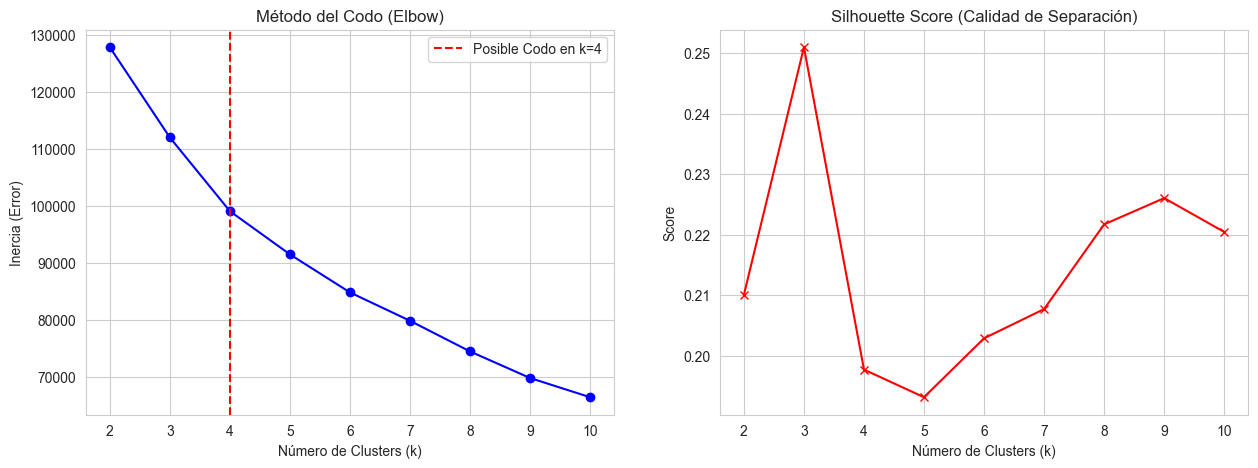

In [7]:
inertia = []
silhouette_scores = []
K_range = range(2, 11)

print("Calculando k óptimo (esto puede tardar unos segundos)...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# --- Gráficas ---
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica 1: Codo
ax[0].plot(K_range, inertia, 'bo-')
ax[0].set_title('Método del Codo (Elbow)')
ax[0].set_xlabel('Número de Clusters (k)')
ax[0].set_ylabel('Inercia (Error)')
ax[0].axvline(x=4, color='r', linestyle='--', label='Posible Codo en k=4')
ax[0].legend()

# Gráfica 2: Silueta
ax[1].plot(K_range, silhouette_scores, 'rx-')
ax[1].set_title('Silhouette Score (Calidad de Separación)')
ax[1].set_xlabel('Número de Clusters (k)')
ax[1].set_ylabel('Score')

plt.show()

**Decisión:** Elegimos **k=4** porque es donde el codo se suaviza y mantenemos una buena interpretabilidad de negocio.

## 5. Entrenamiento del Modelo Final
Ya sabemos que queremos 4 grupos. Ahora le decimos al modelo: "¡Agrupa a todos estos clientes en 4 equipos!".

In [8]:
k_final = 4
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

# ¡Magia! Asignamos la etiqueta del grupo a los datos ORIGINALES
df_clusters = df.copy()
df_clusters['Cluster'] = kmeans_final.labels_

print("¡Agrupación completada!")
print("Cantidad de clientes en cada grupo:")
print(df_clusters['Cluster'].value_counts().sort_index())

¡Agrupación completada!
Cantidad de clientes en cada grupo:
Cluster
0    3977
1     409
2    1197
3    3367
Name: count, dtype: int64


## 6. Interpretación de los Perfiles (Profiling)

Aquí es donde el Data Science se convierte en Negocio. Vamos a ver el comportamiento promedio de cada grupo para ponerles nombre.

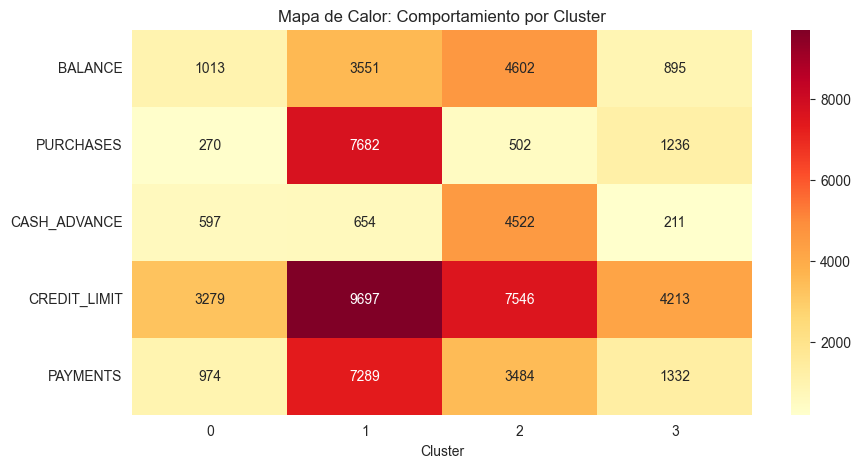

,BALANCE,PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS
Cluster,,,,,
0,1012.658327,270.041785,596.509903,3278.640516,974.260054
1,3551.153761,7681.620098,653.638891,9696.943765,7288.739497
2,4602.449658,501.862982,4521.509581,7546.160857,3484.054216
3,894.907458,1236.178934,210.570626,4213.207678,1332.194205


In [9]:
# Variables clave para analizar
key_features = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']

# Promedios por grupo
cluster_analysis = df_clusters.groupby('Cluster')[key_features].mean()

# Visualización (Mapa de Calor)
plt.figure(figsize=(10, 5))
sns.heatmap(cluster_analysis.T, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Mapa de Calor: Comportamiento por Cluster')
plt.show()

display(cluster_analysis)

### 6.1 Visualización 2D (PCA)
Como no podemos graficar 17 dimensiones, usamos PCA para aplastar los datos a 2D y ver los grupos en un plano.

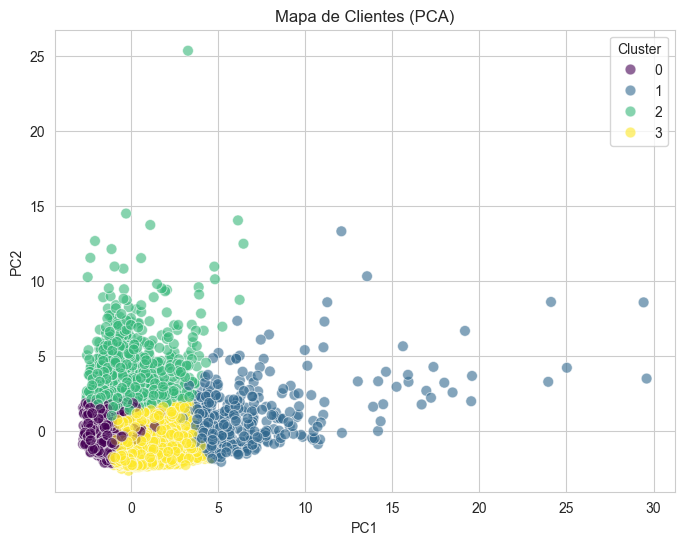

In [10]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df_clusters['Cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=60, alpha=0.6)
plt.title('Mapa de Clientes (PCA)')
plt.show()

## 7. Conclusiones y Aplicación Real

Basado en el Mapa de Calor (los colores rojos indican valores altos), definimos los perfiles:

1.  **Grupo 0 (Ahorradores / Bajo Uso):** 
    *   Tienen bajo balance y pocas compras. Son clientes pasivos.
    *   *Acción:* Enviar ofertas de activación o descuentos iniciales.

2.  **Grupo 1 (Gastadores VIP):** 
    *   **¡Ojo aquí!** Tienen COMPRAS altísimas (`PURCHASES` rojo intenso) y pagan bien. Son los mejores clientes.
    *   *Acción:* Ofrecer tarjeta Black, aumento de cupo y programas de lealtad.

3.  **Grupo 2 (Deudores / Avances de Efectivo):** 
    *   Sacan mucho dinero del cajero (`CASH_ADVANCE` alto) y compran poco.
    *   *Acción:* Ofrecer préstamos personales con mejor tasa (porque ya sabemos que necesitan liquidez).

4.  **Grupo 3 (Balance Alto / Mínimos):** 
    *   Tienen la tarjeta llena (`BALANCE` alto) pero gastan poco. Están pagando deuda vieja.
    *   *Acción:* Cuidar riesgo de impago.